# Analysis of size of control samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_ctrl_size/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'PAC':pal[3], 'PC':pal[7], 'PA':pal[9], 'joint_PC':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette)
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette)
}

### Experiment set-up

```
outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/

for d in $(ls -d $outdir/qPBMC*/); do
    for n in $(seq 3 15); do
        for s in $(seq 12345 12347); do 
            python scripts/run_ctrl_size.py $d $n $s
        done
    done
done
```


### Parse results 

In [11]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [12]:
def _add_perturb_pop_info(pac_design_adata, perturb_pop, min_perturb_cells = 10):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def run_milo(adata_design, query_group, reference_group,
             sample_col= 'sample_id',
             annotation_col= 'cell_type',
             design = '~ is_query'
             ):
            milopy.core.make_nhoods(adata_design, prop=0.1)
            milopy.core.count_nhoods(adata_design, sample_col=sample_col)
            milopy.utils.annotate_nhoods(
                adata_design[adata_design.obs['dataset_group'] == reference_group], annotation_col)
            adata_design.obs['is_query'] = adata_design.obs['dataset_group'] == query_group
            milopy.core.DA_nhoods(adata_design, design=design)

In [13]:
cts_oi = ['natural_killer_cell' ,'classical_monocyte' ,'central_memory_CD4_positive_alpha_beta_T_cell','naive_B_cell','effector_memory_CD8_positive_alpha_beta_T_cell']
dirs = [f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]

In [14]:
dirs

['qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022']

In [15]:
import warnings 

nhood_obs_all = pd.DataFrame()
# with warnings.catch_warnings():
    # warnings.simplefilter("ignore")
for d in [outdir + d for d in dirs]:
    print(f'Parsing {d}')
    for ctrl_d in os.listdir(d + '/ctrl_size_analysis_nquery5/'):
        ctrl_sim_dir = d + '/ctrl_size_analysis_nquery5/' + ctrl_d
        n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
        sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

        perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
        pac_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PAC_design.h5ad', backed=True)
        pac_design_adata.obs['dataset_group'] = np.where(pac_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

        pc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PC_design.h5ad', backed=True)
        pc_design_adata.obs['dataset_group'] = np.where(pc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')
        
        jpc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/jointPC_design.h5ad', backed=True)
        jpc_design_adata.obs['dataset_group'] = np.where(jpc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

        run_milo(pc_design_adata, query_group='query', reference_group='ctrl')
        _add_perturb_pop_info(pc_design_adata, perturb_pop)
        
        run_milo(jpc_design_adata, query_group='query', reference_group='ctrl')
        _add_perturb_pop_info(jpc_design_adata, perturb_pop)

        run_milo(pac_design_adata, query_group='query', reference_group='ctrl')
        _add_perturb_pop_info(pac_design_adata, perturb_pop)

        ## Store nhood info
        des_dict = {'PAC':pac_design_adata, "PC": pc_design_adata, 'joint_PC': jpc_design_adata}
        for design, adata in des_dict.items():
            nhood_obs = get_nhood_adata(adata).obs.copy()
            nhood_obs['design'] = design
            nhood_obs['perturb_pop'] = perturb_pop
            nhood_obs['n_ctrls'] = n_ctrls
            nhood_obs['random_seed'] = sim_seed
            nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

<AxesSubplot:xlabel='logFC', ylabel='frac_perturb_cells'>

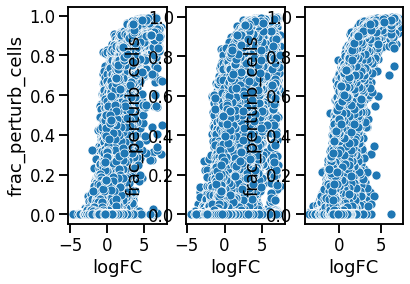

In [20]:
plt.subplot(1,3,1);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PAC'], x='logFC', y='frac_perturb_cells' );
plt.subplot(1,3,2);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PC'], x='logFC', y='frac_perturb_cells' )
plt.subplot(1,3,3);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'joint_PC'], x='logFC', y='frac_perturb_cells' )

In [16]:
nhood_obs_all.to_csv(outdir + '/ctrl_size_nhood_obs_all_nquery5.csv')

In [18]:
outdir + '/ctrl_size_nhood_obs_all_nquery5.csv'

'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered//ctrl_size_nhood_obs_all_nquery5.csv'

## Compute Area under precision-recall curve

In [23]:
from sklearn.metrics import auc, precision_recall_curve

def _compute_AUPRC(out_df):    
    precision, recall, _ = precision_recall_curve(out_df.is_perturb_nhood, out_df['logFC'])
    no_skill = sum(out_df.is_perturb_nhood) / out_df.shape[0]
    AUC = auc(recall, precision)
    AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=['Recall','Precision']).T
    AUPRC_df['AUPRC'] = AUC
    AUPRC_df['no_skill_thresh'] = no_skill
    return(AUPRC_df)


In [24]:
nhood_obs_all['simulation_ID'] = nhood_obs_all.design + "_" + nhood_obs_all.perturb_pop + "_" + nhood_obs_all.n_ctrls.astype('str') + "_" + nhood_obs_all.random_seed.astype('str')

In [42]:
AUPRC_df_all = pd.DataFrame()
for s in nhood_obs_all['simulation_ID'].unique():
    nhood_obs = nhood_obs_all[nhood_obs_all['simulation_ID'] == s]
    AUPRC_df = _compute_AUPRC(nhood_obs)
    AUPRC_df['simulation_ID'] = s
    AUPRC_df['perturb_pop'] = nhood_obs['perturb_pop'][0]
    AUPRC_df['design'] = nhood_obs['design'][0]
    AUPRC_df['n_ctrl'] = nhood_obs['n_ctrls'][0]
    AUPRC_df_all = pd.concat([AUPRC_df_all, AUPRC_df])
AUPRC_df_all = AUPRC_df_all[['AUPRC', 'no_skill_thresh', 'simulation_ID', 'design', 'n_ctrl', 'perturb_pop']].drop_duplicates()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [43]:
%%R -i AUPRC_df_all
head(AUPRC_df_all)

      AUPRC no_skill_thresh                   simulation_ID   design n_ctrl
1 0.6252028      0.12912482       PAC_memory_B_cell_9_12345      PAC      9
2 0.4721631      0.13281250        PC_memory_B_cell_9_12345       PC      9
3 0.6161575      0.08912189  joint_PC_memory_B_cell_9_12345 joint_PC      9
4 0.1361246      0.14340589      PAC_memory_B_cell_11_12346      PAC     11
5 0.1645678      0.13707865       PC_memory_B_cell_11_12346       PC     11
6 0.4129125      0.07861272 joint_PC_memory_B_cell_11_12346 joint_PC     11
    perturb_pop
1 memory_B_cell
2 memory_B_cell
3 memory_B_cell
4 memory_B_cell
5 memory_B_cell
6 memory_B_cell


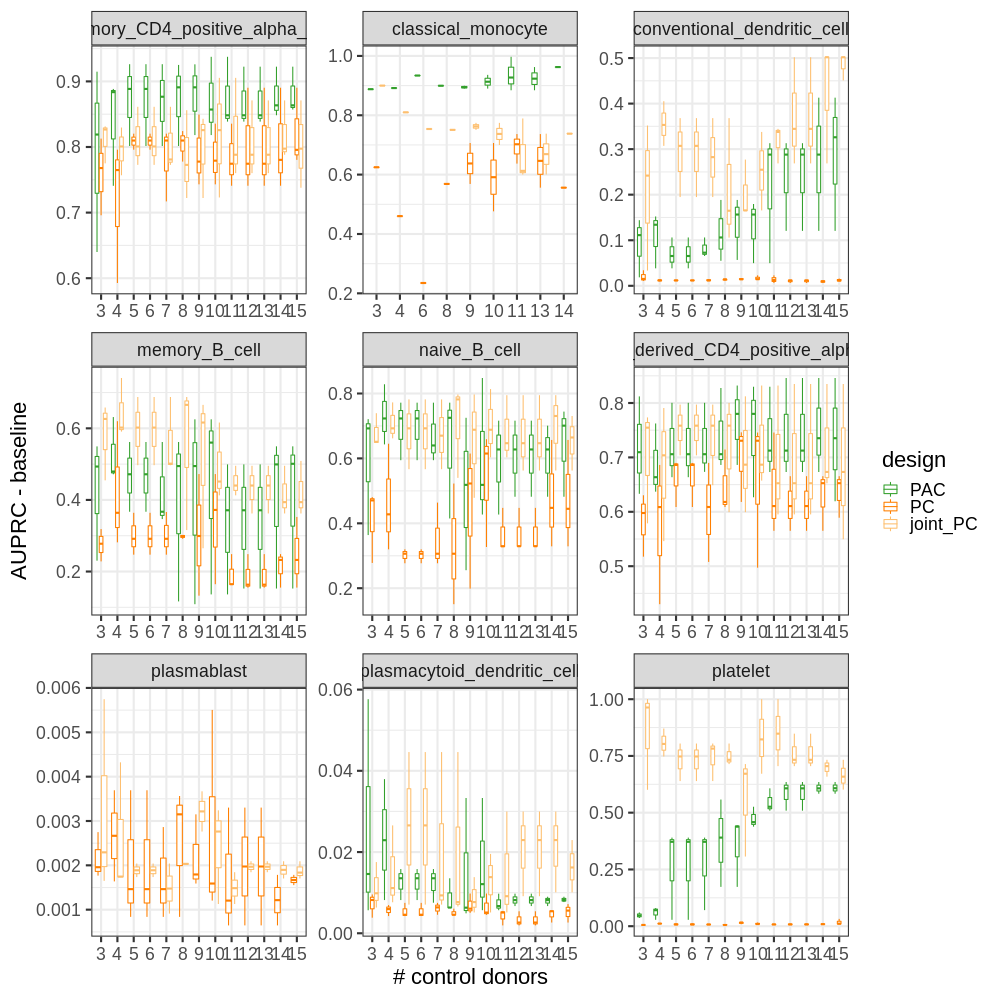

In [71]:
%%R -w 1000 -h 1000
auprc_pl <- AUPRC_df_all %>%
    mutate(design = factor(design, levels=c('PAC', 'PC', 'joint_PC'))) %>%
    ggplot(aes(as.factor(n_ctrl), AUPRC, color=design)) +
    geom_boxplot() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    xlab('# control donors') +
    facet_wrap(perturb_pop~., scales='free') +
    ylab('AUPRC - baseline')

auprc_pl

## Compute TPR/FPR

In [49]:
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha) & (nhood_obs_all.logFC > 0)
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood']) & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

In [50]:
tpr_df = nhood_obs_all.groupby(['design', 'perturb_pop', 'n_ctrls', 'simulation_ID']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
tpr_df['TPR'] = tpr_df['TP'] / (tpr_df['TP'] + tpr_df['FN'])
tpr_df['FPR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TN'])
tpr_df['FDR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df['Precision'] = tpr_df['TP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df['F1'] = ((tpr_df['Precision'] * tpr_df['TPR']) / (tpr_df['Precision'] + tpr_df['TPR'])) * 2
tpr_df.loc[tpr_df['FDR'].isna(), 'FDR'] = 0
tpr_df['design'] = tpr_df['design'].astype('category').cat.reorder_categories(['PAC', "PC", "joint_PC"])
tpr_df

,design,perturb_pop,n_ctrls,simulation_ID,TP,FP,FN,TN,TPR,FPR,FDR,Precision,F1
0,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,242,326,0.000000,0.0,0.0,NaN,NaN
1,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,236,371,0.000000,0.0,0.0,NaN,NaN
2,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,79,0,139,350,0.362385,0.0,0.0,1.0,0.531987
3,PAC,central_memory_CD4_positive_alpha_beta_T_cell,4,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,250,343,0.000000,0.0,0.0,NaN,NaN
4,PAC,central_memory_CD4_positive_alpha_beta_T_cell,4,PAC_central_memory_CD4_positive_alpha_beta_T_c...,14,0,225,406,0.058577,0.0,0.0,1.0,0.110672
...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,joint_PC,platelet,14,joint_PC_platelet_14_12346,6,0,4,922,0.600000,0.0,0.0,1.0,0.750000
974,joint_PC,platelet,14,joint_PC_platelet_14_12347,3,0,6,799,0.333333,0.0,0.0,1.0,0.500000
975,joint_PC,platelet,15,joint_PC_platelet_15_12345,5,0,4,856,0.555556,0.0,0.0,1.0,0.714286
976,joint_PC,platelet,15,joint_PC_platelet_15_12346,6,0,4,922,0.600000,0.0,0.0,1.0,0.750000


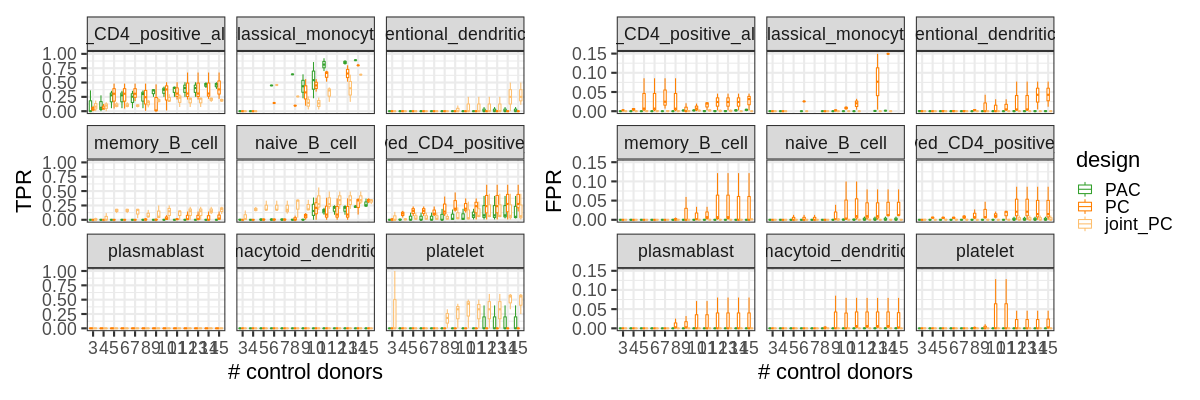

In [57]:
%%R -i tpr_df -w 1200 -h 400
tpr_pl <- tpr_df %>%
ggplot(aes(as.factor(n_ctrls), TPR, color=design)) +
    geom_boxplot() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    ylim(0,1) +
    facet_wrap(perturb_pop~.) +
    xlab('# control donors') 

fpr_pl <- tpr_df %>%
    ggplot(aes(as.factor(n_ctrls), FPR, color=design)) +
    geom_boxplot() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    facet_wrap(perturb_pop~.) +
    xlab('# control donors') 

    
(tpr_pl + fpr_pl) +
plot_layout(guides='collect')

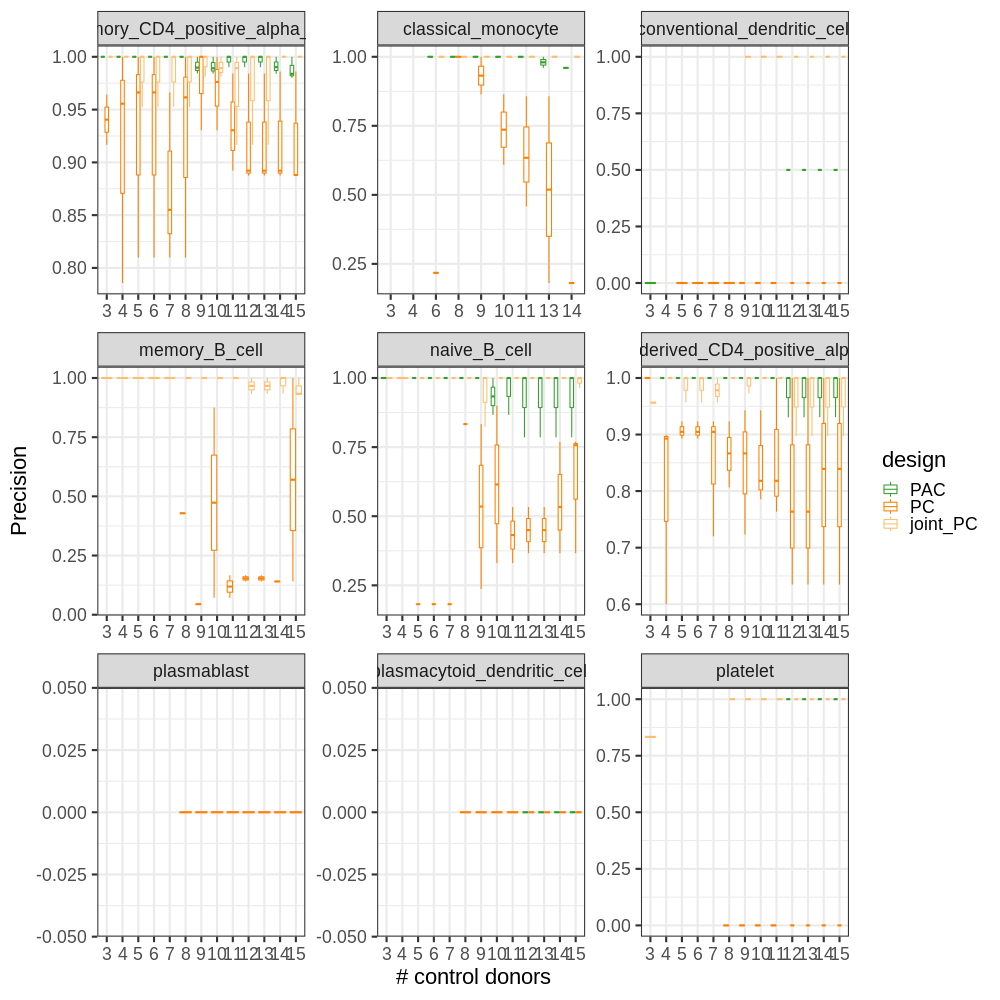

In [79]:
%%R -w 1000 -h 1000
tpr_df %>%
    group_by(n_ctrls, design, perturb_pop) %>%
    mutate(mean_TPR = mean(TPR), mean_FPR = mean(FPR), mean_FDR = mean(FDR), mean_precision=mean(Precision)) %>%
    ungroup() %>%
    ggplot(aes(as.factor(n_ctrls), Precision, color=design)) +
    geom_boxplot() +
    # geom_line(aes(y=mean_precision), size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    facet_wrap(perturb_pop~., scales='free') +
    xlab('# control donors') 

True     7505
False    2878
Name: is_query, dtype: int64